In [1]:
import glob
from os import makedirs
import os 
import scipy
import imageio
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import mean_squared_error
import math
from config import config
import pickle
import sklearn
import dataset
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.


In [2]:
config_pro = tf.ConfigProto()
config_pro.gpu_options.allow_growth = False
config_pro.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(config=config_pro)
K.set_session(sess)

In [3]:
data = dataset.DLoader(config, augment=True)
test_data = dataset.DLoader(config, augment=False)

Batch size: 4, Thread num: 10
in shape: [None, None, 1] label shape: [None, None, 1]
load dataset done
data size: 700
Batch size: 4, Thread num: 10
in shape: [None, None, 1] label shape: [None, None, 1]
load dataset done
data size: 700


In [8]:
def split_all_data(all_samps, train_val_test_split=[0.7, 0.15, 0.15]):
    all_samps = sklearn.utils.shuffle(all_samps)
    all_samps = [os.path.basename(x).split('.')[0] for x in all_samps]
    train_val_test_split = [0.7, 0.15, 0.15]
    assert np.sum(train_val_test_split) == 1, print('train_val_test_split should be 1.0')
    num_samps = len(all_samps)
    x_train, x_val, x_test = all_samps[:int(num_samps*train_val_test_split[0])],\
    all_samps[int(num_samps*train_val_test_split[0]):-int(num_samps*train_val_test_split[2])],\
    all_samps[-int(num_samps*train_val_test_split[2]):]
    print('{} train smaps, {} val samps, {} test samps. total: {}'.format(
        len(x_train), len(x_val), len(x_test), len(x_train) + len(x_val) + len(x_test)))
    return x_train, x_val, x_test


def pickle_data(x_train, x_val, x_test, path):
    with open(path, 'wb') as f:
        pickle.dump({'x_train': x_train,
                     'x_val': x_val,
                     'x_test': x_test}, f)
    print('data saved to path:', path)

In [5]:
x_train, x_val, x_test = split_all_data(all_samps)

700 train smaps, 150 val samps, 150 test samps. total: 1000


In [9]:
data_path = config['data_root'] + '/train_val_lists.pickle'
pickle_data(x_train, x_val, x_test, data_path)

data saved to path: /Users/aviavidan/data/viz/train_val_lists.pickle


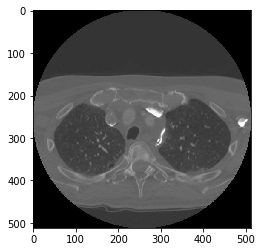

In [8]:
img_path = os.path.join(config['data_root'], 'jpg', data.val_data[0]+ '.jpg')
img = get_img(img_path, print_shape=False, plot=True)

since there is a lot of similarity bw consequitive slices I dont want to train on slice Xi and then test on Xi+1, so to minimize this type of 'over fit' risk - 
1. I would test on patients that were not part of the training/validation
2. I would split train-validation randomly while making sure minimal similarity per patient

In [6]:
def get_files(path, ftype='jpg', fprint=True):
    file_list = glob.glob(path + '*.' + ftype)
    if fprint:
        print('{} files of type {} in path {}'.format(len(file_list), ftype, path))
    return file_list

def create_dir(path):
    if not exists(path):
        try:
            makedirs(path)
            print('created directory:', path)
        except:
            print('could not create directory:', path, 'exiting')
            pass
    else:
        print('path exists')

def seperate_by_ftype(data_root, ftypes=['bmp','jpg'], show_images=True):
    for ftype in ftypes:
        destination_folder = data_root + ftype
        create_dir(destination_folder)

        flist = get_files(data_root, ftype=ftype)

        for file in flist:
            new_path = destination_folder + '/' + file.split('/')[-1]
            rename(file, new_path)

def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()
    plt.clf()
    
def get_img(path, print_shape=False, plot=False):
    img = imageio.imread(path)
    if print_shape:
        print('img_shape:', img.shape)
    if plot:
        plot_img(img)
    return img
    
def plot_random_img(path, ftype='*'):
    flist = get_files(path, ftype=ftype)
    file_path = flist[randint(0, len(flist)-1)]
    print('showing ramdom image of type:', path[-4:-1])
    
    return file_path, img


def get_matching_path_of_other_type(fname):
    if 'jpg' in fname:
        return fname.replace('jpg', 'bmp')
    return fname.replace('bmp', 'jpg')
    
    
    
def plot_one_of_each(samp_path):
    img = get_img(samp_path, print_shape=False, plot=False)
    label_path = get_matching_path_of_other_type(samp_path)
    label = get_img(label_path, print_shape=False, plot=False)
    f, ax = plt.subplots(1, 3, figsize=(16,8))
    ax[0].imshow(img)
    ax[1].imshow(label)
    ax[2].imshow(label-img, cmap='hot')
    ax[0].set_title(os.path.basename(samp_path))
    ax[1].set_title(os.path.basename(label_path))
    ax[2].set_title('diff')
    plt.show()
    return img, label


def get_img_stats(img, print_stats=False):
    img_max, img_min, img_mean, img_std = np.max(img), np.min(img), np.mean(img), np.std(img)
    if print_stats:
        print('max: {}, min: {}, mean: {}, std: {}'.format(img_max, img_min, img_mean, img_std))
    return img_max, img_min, img_mean, img_std
    

def plot_dif(img1, img2, print_stats=True, plot=False):
    #dif = np.uint8(img1) - np.uint8(img2)
    dif = img2 - img1
    if print_stats:
        get_img_stats(img1, print_stats=print_stats)
        get_img_stats(img2, print_stats=print_stats)
        get_img_stats(dif, print_stats=print_stats)
    if plot:
        plot_img(dif)
    return dif

def get_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
# seperate_by_ftype(path)    

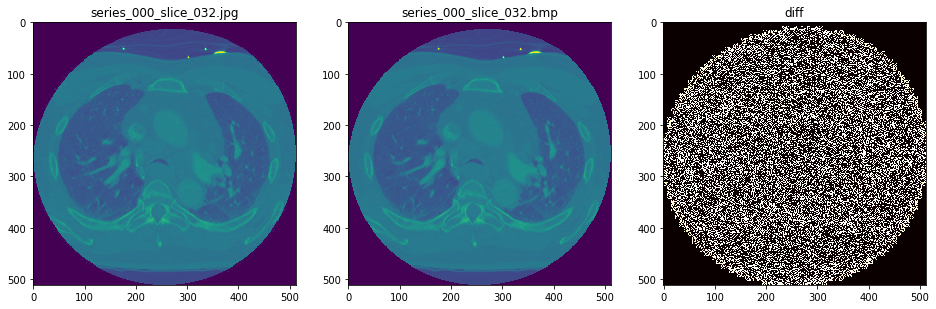

max: 255, min: 0, mean: 71.98213577270508, std: 43.390089563945196
max: 255, min: 0, mean: 71.92044448852539, std: 43.497318749492585
max: 255, min: 0, mean: 74.68537902832031, std: 115.20281263535122
dif rmse: 1.7993
(512, 512) (512, 512)


In [13]:
samp_ind = random.randint(0, len(all_samps)-1)
jpg_img, bmp_img = plot_one_of_each(all_samps[samp_ind])
dif = plot_dif(jpg_img, bmp_img)
print('dif rmse: {:.4f}'.format(get_rmse(jpg_img, bmp_img)))
# print(jpg_img.shape, bmp_img.shape)

In [19]:
def avg_rmse(root_path):
    predicted_list = get_files(root_path+'jpg/')
    sum_rmse = 0
    for file in predicted_list:
        predicted_img = get_img(file)
        pfile = get_matching_path_of_other_type(file)
        actual_img = get_img(pfile)
        sum_rmse += get_rmse(actual_img, predicted_img)
    return sum_rmse/len(predicted_list)

In [24]:
get_rmse(im1, im2)

NameError: name 'avg_rmse' is not defined

In [20]:
avg_rmse(data_root)

1000 files of type jpg in path ./takehome/jpg/


1.6470815873401714